In [11]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image
from src.config import load_config
from src.data import (
    load_labels,
    validate_schema,
    resolve_image_paths,
    check_missing_files,
    get_sample,
)

PROJECT_ROOT = Path.cwd().parent


cfg = load_config(PROJECT_ROOT / "configs/default.yaml").raw
cfg

{'project': {'name': 'age-prediction',
  'seed': 42,
  'device': 'gpu',
  'output_dir': 'reports'},
 'data': {'csv_path': 'data/labels.csv',
  'images_dir': 'data/images',
  'filename_col': 'file_name',
  'target_col': 'real_age',
  'image_size': [224, 224],
  'channels': 3,
  'batch_size': 32,
  'val_size': 0.15,
  'test_size': 0.15,
  'stratify_bins': 10,
  'cache': False,
  'prefetch': True},
 'model': {'backbone': 'ResNet50',
  'weights': 'imagenet',
  'pooling': 'avg',
  'dropout': 0.2,
  'dense_units': 128,
  'l2': 0.0},
 'train': {'epochs_stage1': 8,
  'epochs_stage2': 12,
  'lr_stage1': 0.001,
  'lr_stage2': 5e-05,
  'fine_tune_N_last': 30,
  'optimizer': 'adam',
  'loss': 'mae',
  'metrics': ['mae']},
 'callbacks': {'early_stopping_patience': 5,
  'reduce_lr_patience': 2,
  'reduce_lr_factor': 0.2,
  'min_lr': 1e-07},
 'artifacts': {'save_best': True,
  'best_model_path': 'models/best.keras',
  'history_path': 'reports/metrics/history.csv',
  'metrics_path': 'reports/metrics/t

In [2]:
# Load CSV labels

df = load_labels(PROJECT_ROOT / cfg["data"]["csv_path"])
display(df.head())

# Validate schema
validate_schema(df, filename_col=cfg["data"]["filename_col"], label_col=cfg["data"]["target_col"])

print(f'Df shape: {df.shape}')

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


Df shape: (7591, 2)


In [3]:
# Check duplicated filenames and quick statistics
file_name = cfg["data"]["filename_col"]
target_col = cfg["data"]["target_col"]
num_duplicates = df.duplicated(subset=[file_name]).sum()
print(f'Number of duplicated filenames: {num_duplicates}')
print(f'Label statistics:\n{df[target_col].describe()}')

Number of duplicated filenames: 0
Label statistics:
count    7591.000000
mean       31.201159
std        17.145060
min         1.000000
25%        20.000000
50%        29.000000
75%        41.000000
max       100.000000
Name: real_age, dtype: float64


In [7]:
# Resolve image paths and check for missing files
image_dir = PROJECT_ROOT / cfg["data"]["images_dir"]
paths = resolve_image_paths(df, image_dir, filename_col=file_name)
missing, missing_rate = check_missing_files(paths)
print(f'Number of missing image files: {missing.count()} ({missing_rate:.2%} missing)')

Number of missing image files: 0 (0.00% missing)


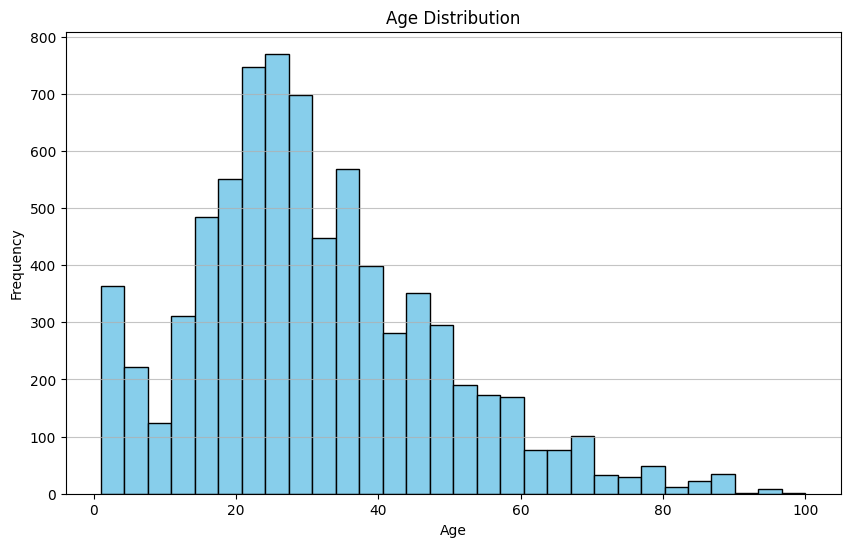

In [8]:
# Age distribution plot
plt.figure(figsize=(10, 6))
plt.hist(df[target_col], bins=30, color='skyblue', edgecolor='black')
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()


In [9]:
# Age percentiles to check outliers
df[target_col].quantile([0.01, 0.05, 0.50, 0.95, 0.99])


0.01     1.0
0.05     5.0
0.50    29.0
0.95    63.0
0.99    82.0
Name: real_age, dtype: float64

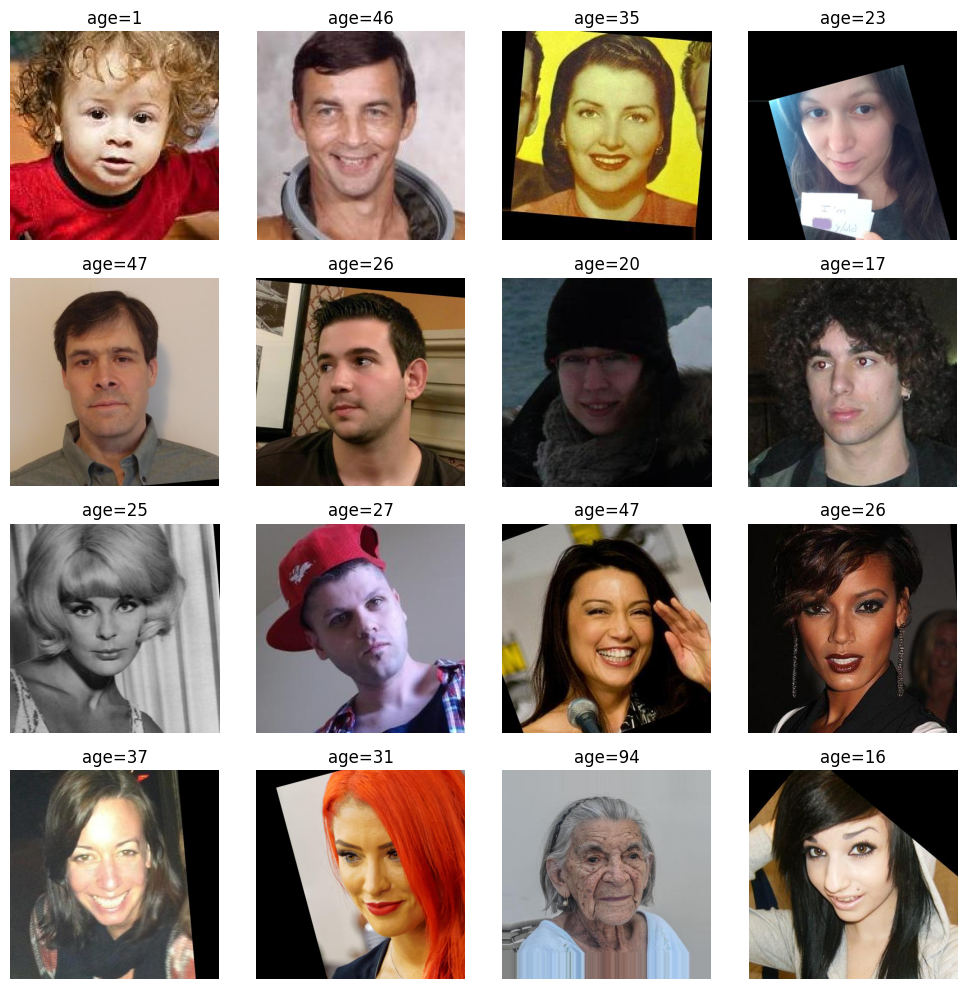

In [ ]:
# Images sanity check

sample = get_sample(df, n=16, seed=int(cfg["project"]["seed"]))
sample_paths = resolve_image_paths(sample,image_dir, file_name)

fig, axes = plt.subplots(4, 4, figsize=(10, 10))
for ax, (p, age) in zip(axes.ravel(), zip(sample_paths, sample[target_col])):
    img = Image.open(p).convert("RGB")
    ax.imshow(img)
    ax.set_title(f"age={age}")
    ax.axis("off")

plt.tight_layout()
plt.show()

# Observations
- The dataset contains a total of 7,591 images with corresponding age labels.
- There are no duplicated or missing filenames in the dataset.
- The age labels range from 0 to 100, with a mean age of approximately 31 years.
- The age distribution is concentrated between 15 and 40 years, with fewer samples at the extremes (very young and very old ages).